In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc
try:
    from sklearn.preprocessing import MinMaxScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)
# print("Project root in sys.path:", root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS
)
from src.data_loading import load_cmapps_subset, get_feature_drop_cols
from src.additional_features import create_physical_features
from src.training import train_and_evaluate_fd
from src.model import LSTMRULPredictor
from src.loss import rul_asymmetric_weighted_loss


In [2]:
from src.data_loading import load_cmapps_subset

df_train_fd2, df_test_fd2, y_fd2 = load_cmapps_subset("FD002")

print(df_train_fd2[["Setting1", "Setting2", "Setting3", "ConditionID"]].head())
print("Train ConditionIDs:", df_train_fd2["ConditionID"].unique())
print("Test  ConditionIDs:", df_test_fd2["ConditionID"].unique())

[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
   Setting1  Setting2  Setting3  ConditionID
0   34.9983    0.8400     100.0            0
1   41.9982    0.8408     100.0            1
2   24.9988    0.6218      60.0            2
3   42.0077    0.8416     100.0            1
4   25.0005    0.6203      60.0            2
Train ConditionIDs: [0 1 2 3 4 5 6]
Test  ConditionIDs: [5 3 0 1 2 6 4]


In [3]:


res_fd002_cond, metrics_fd002_cond = train_and_evaluate_fd(
    fd_id="FD002",
    model_class=LSTMRULPredictor,
    loss_fn=rul_asymmetric_weighted_loss,
    use_condition_id=True,    # ConditionID-Ansatz
)

res_fd002_phys, metrics_fd002_phys = train_and_evaluate_fd(
    fd_id="FD002",
    model_class=LSTMRULPredictor,
    loss_fn=rul_asymmetric_weighted_loss,
    use_condition_id=False,   # physikalischer Ansatz
)


=== Training subset FD002: 6 cond, 1 fault (HPC) ===
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.940506        6.8       0.408741  125
1             0.941593        2.8       0.406364  125
2             0.934608      -18.2       0.427536  125
3             0.944099        1.8       0.405833  125
4             0.938646      -18.2       0.427022  125
New columns successfully added. Current number of columns: 30
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio
0             0.942084       31.9       0.404116
1             0.943055       26.9       0.410356
2             0.945699       -4.1       0.409100
3             0.939888       -5.1       0.407627
4             0.936330      -32.1       0.428286
[FD002] Using CONDITION-ID feature set


In [5]:
res_fd002_cond, metrics_fd004_cond = train_and_evaluate_fd(
    fd_id="FD004",
    model_class=LSTMRULPredictor,
    loss_fn=rul_asymmetric_weighted_loss,
    use_condition_id=True,    # ConditionID-Ansatz
)

res_fd004_phys, metrics_fd004_phys = train_and_evaluate_fd(
    fd_id="FD004",
    model_class=LSTMRULPredictor,
    loss_fn=rul_asymmetric_weighted_loss,
    use_condition_id=False,   # physikalischer Ansatz
)


=== Training subset FD004: 6 cond, 2 faults (HPC+Fan) ===
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.944817       -3.6       0.409162  125
1             0.941253       27.4       0.410169  125
2             0.938052       -4.6       0.408713  125
3             0.940716       -5.6       0.409099  125
4             0.938737      -28.6       0.427093  125
New columns successfully added. Current number of columns: 30
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio
0             0.941387       27.6       0.409624
1             0.937808      -28.4       0.426869
2             0.946410       -6.4       0.409833
3             0.943525       -6.4       0.409935
4             0.942366       -1.4       0.410261
[FD004] Using CONDITION-ID feature

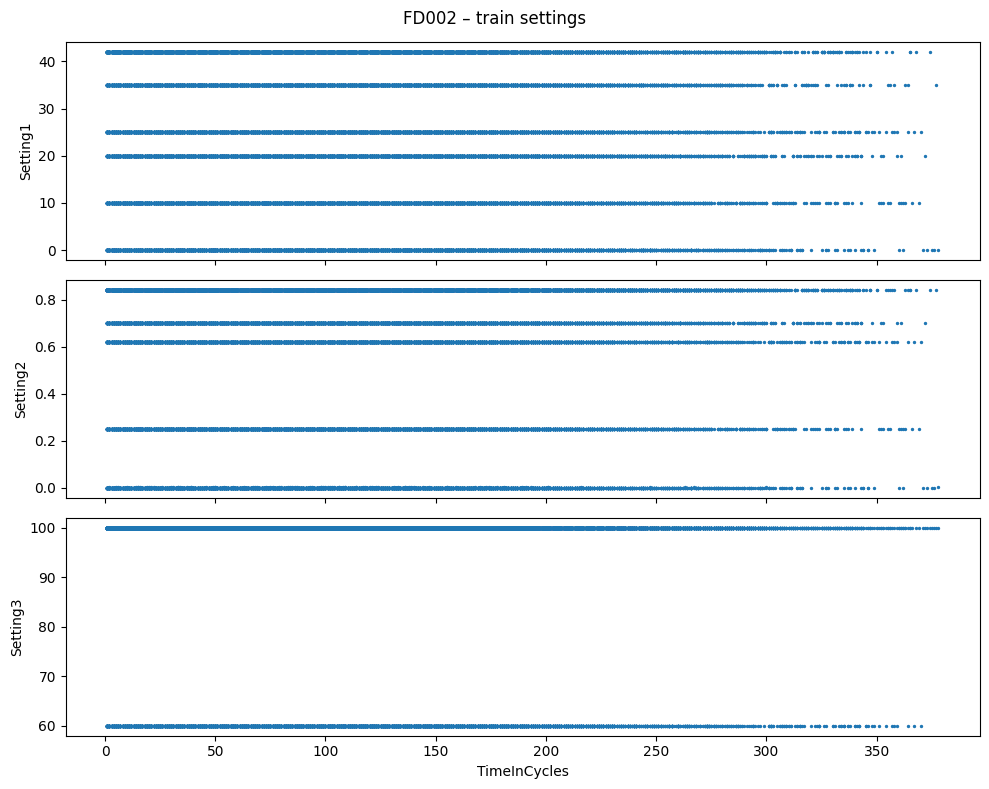

In [6]:
import matplotlib.pyplot as plt

def plot_settings_over_time(df, title="Operating settings over time"):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    axes[0].scatter(df["TimeInCycles"], df["Setting1"], s=2)
    axes[0].set_ylabel("Setting1")

    axes[1].scatter(df["TimeInCycles"], df["Setting2"], s=2)
    axes[1].set_ylabel("Setting2")

    axes[2].scatter(df["TimeInCycles"], df["Setting3"], s=2)
    axes[2].set_ylabel("Setting3")
    axes[2].set_xlabel("TimeInCycles")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Beispiel:
plot_settings_over_time(df_train_fd2, title="FD002 – train settings")

In [7]:
print("unique Setting1 (gerundet):", df_train_fd2["Setting1"].round(0).unique())
print("unique Setting2 (gerundet):", df_train_fd2["Setting2"].round(1).unique())
print("unique Setting3 (gerundet):", df_train_fd2["Setting3"].round(0).unique())


unique Setting1 (gerundet): [35. 42. 25. 20.  0. 10.]
unique Setting2 (gerundet): [0.8 0.6 0.7 0.  0.3 0.2]
unique Setting3 (gerundet): [100.  60.]


In [8]:
df_train_fd2_rounded = df_train_fd2.copy()
df_train_fd2_rounded["S1_r"] = df_train_fd2_rounded["Setting1"].round(0)
df_train_fd2_rounded["S2_r"] = df_train_fd2_rounded["Setting2"].round(1)
df_train_fd2_rounded["S3_r"] = df_train_fd2_rounded["Setting3"].round(0)

unique_conditions = (
    df_train_fd2_rounded[["S1_r", "S2_r", "S3_r"]]
    .drop_duplicates()
    .sort_values(["S1_r", "S2_r", "S3_r"])
)

print("Unique rounded (Setting1, Setting2, Setting3) combos:")
print(unique_conditions)
print("Number of combos:", len(unique_conditions))


Unique rounded (Setting1, Setting2, Setting3) combos:
    S1_r  S2_r   S3_r
11   0.0   0.0  100.0
30  10.0   0.2  100.0
14  10.0   0.3  100.0
7   20.0   0.7  100.0
2   25.0   0.6   60.0
0   35.0   0.8  100.0
1   42.0   0.8  100.0
Number of combos: 7


In [9]:
cond_counts = (
    df_train_fd2_rounded
    .groupby(["S1_r", "S2_r", "S3_r"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print(cond_counts)


   S1_r  S2_r   S3_r  count
6  42.0   0.8  100.0  13458
3  20.0   0.7  100.0   8122
0   0.0   0.0  100.0   8044
5  35.0   0.8  100.0   8037
4  25.0   0.6   60.0   8002
1  10.0   0.2  100.0   4138
2  10.0   0.3  100.0   3958
